<a href="https://colab.research.google.com/github/mrubio93/undernourishment/blob/main/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

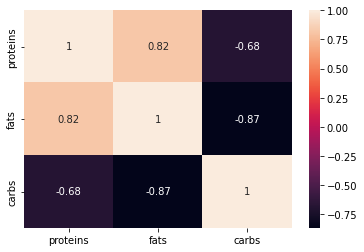

In [4]:
import pandas as pd
import os
import seaborn as sn

path = os.getcwd()
# Import data from the current working directory
df = pd.read_excel(path + "/data.xlsx")
df_groups = df.groupby(['Area', 'Year Code'], as_index = False).sum()

# Rename columns
df_groups = df_groups.rename(columns={'Share of dietary energy supply derived from cereals, roots and tubers (kcal/cap/day) (3-year average)': 'carbs'})
df_groups = df_groups.rename(columns={'Average protein supply (g/cap/day) (3-year average)': 'proteins'})
df_groups = df_groups.rename(columns={'Average fat supply (g/cap/day) (3-year average)': 'fats'})
df_groups = df_groups.rename(columns={'Prevalence of undernourishment (percent) (3-year average)': 'undernourishment'})
df_groups = df_groups.reset_index()

# Delete rows = 0
for i in df_groups.columns[3:]:
    df_groups = df_groups.drop(df_groups[df_groups[i] == 0].index)

import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)



    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Define predictors and targets
df_predictors = df_groups[['proteins','fats','carbs']]
df_target = df_groups[['undernourishment']]

# Prepare data
y = df_target['undernourishment'].to_numpy()

# Correlation matrix
corr = df_predictors.corr()
sn.heatmap(corr, annot=True)

In [5]:
#%% Feature selection and scaling
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

X = df_predictors.to_numpy()

# Select best variable
X.shape
X = SelectKBest(f_regression, k = 1).fit_transform(X, y)

# Scale the variable to see how it works:
scaler = StandardScaler().fit(X) # scaler keep data (mean and sd) from X, useful for further scaling with same parameters
X = scaler.fit_transform(X)


In [7]:
#%% linear regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X, df_target.undernourishment)

# Model coeficients: weights
reg.coef_
reg.intercept_

# Predict one value (example)
reg.predict([[51.4]])

# R^2
print(reg.score(X, df_target.undernourishment, sample_weight=None))

0.5586642795827923


In [9]:
#%% Methods (svr, kr)
# https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_ridge_regression.html?highlight=kernel%20ridge

# Grid Search
C_range = (1, 50, 100)
gamma_range = (0.01, 0.1, 0.5, 1)
cv = KFold(n_splits=5)

svr = GridSearchCV(
    SVR(kernel="rbf", gamma=0.01),
    param_grid={"C": C_range, "gamma": gamma_range}, cv=cv, n_jobs=-1
)

kr = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.01),
    param_grid={"alpha": [1, 0.1, 1e-2, 1e-3], "gamma": gamma_range}, cv=cv, n_jobs=-1
)

svr_lin = GridSearchCV(
    SVR(kernel="linear", gamma=0.01),
    param_grid={"C": C_range, "gamma": gamma_range}, cv=cv, n_jobs=-1
)

svr_poly = GridSearchCV(
    SVR(kernel="poly", gamma=0.01, degree=2),
    param_grid={"C": C_range, "gamma": gamma_range}, cv=cv, n_jobs=-1
)

# redefine variables
df_all_var = df_groups[['carbs','proteins','fats']]
df_prot_carbs = df_groups[['carbs', 'proteins']]
df_prot_fats = df_groups[['proteins','fats']]
df_carbs_fats = df_groups[['carbs','fats']]
df_prots = df_groups[['proteins']]
df_all_var.name, df_prot_carbs.name, df_prot_fats.name, df_carbs_fats.name, df_prots.name= "All", "Proteins and Carbs",\
    "Proteins and Fats", "Carbs and Fats", "Proteins"

# Create a df with all the datasets to try
df_list = [df_all_var, df_prot_carbs, df_prot_fats, df_carbs_fats, df_prots]
list_method = {"Method" : ["SVR (rbf)", "Kernel Ridge", "SVR (linear)", "SVR (poly)"]}

new_df = pd.DataFrame(data = list_method)

# Run the models for the different datasets stored in df_list
for array in df_list:
    list_scores = []
    name = array.name
    X = array.to_numpy()
    scaler = StandardScaler().fit(X) # scaler conserva los datos (media y sd) de X, para escalar futuros inputs
    X = scaler.fit_transform(X)
    svr.fit(X,y)
    kr.fit(X, y)
    svr_lin.fit(X,y)
    svr_poly.fit(X, y)
    
    print(
        "The best parameters for SVR (rbf) on", name,"are %s with a score of %0.2f"
        % (svr.best_params_, svr.best_score_)
    )
    
    print(
        "The best parameters for Kernel Ridge on", name,"are %s with a score of %0.2f"
        % (kr.best_params_, kr.best_score_)
    )
    
    print(
        "The best parameters for SVR (linear)", name,"are %s with a score of %0.2f"
        % (svr_lin.best_params_, svr_lin.best_score_)
    )
    
    print(
        "The best parameters for SVR (poly)", name,"are %s with a score of %0.2f"
        % (svr_poly.best_params_, svr_poly.best_score_)
    )
    list_scores = [svr.best_score_, kr.best_score_, svr_lin.best_score_, svr_poly.best_score_]
    new_df[name] = list_scores
    
    # Validation plots
    # SVR
    scores = svr.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.5, midpoint=0.6))
    plt.xlabel("gamma")
    plt.ylabel("C")
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title(f"Validation accuracy - SVR - {name}")
    plt.show()
    
    #Kernel Ridge
    scores = kr.cv_results_["mean_test_score"].reshape(4, len(gamma_range))
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.5, midpoint=0.6))
    plt.xlabel("gamma")
    plt.ylabel("alpha")
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(4), (0.01, 0.1, 1e-2, 1e-3))
    plt.title(f"Validation accuracy - Kernel Ridge - {name}")
    plt.show()

print(new_df)


         Method       All  Proteins and Carbs  Proteins and Fats  \
0     SVR (rbf)  0.719799            0.696972           0.705869   
1  Kernel Ridge  0.729724            0.701985           0.704850   
2  SVR (linear)  0.509050            0.505930           0.481710   
3    SVR (poly) -0.082007           -0.153079          -0.164442   

   Carbs and Fats  Proteins  
0        0.534570  0.685688  
1        0.560571  0.691863  
2        0.348949  0.482440  
3       -0.147930 -0.190651  


In [10]:
#%% Neural network
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

param_grid = {"hidden_layer_sizes" : [(100,), (150,)]}
nngrid = GridSearchCV(MLPRegressor(random_state=1, max_iter=5000, solver="adam"), param_grid)

for array in df_list:
    list_scores = []
    name = array.name
    X = array.to_numpy()
    scaler = StandardScaler().fit(X)
    X = scaler.fit_transform(X)
    y = df_target['undernourishment'].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =1)
    nngrid.fit(X, y)

    print("The result for",name," is: ", nngrid.best_score_, "and params are", nngrid.best_params_)


The result for All  is:  0.69437615475715 and params are {'hidden_layer_sizes': (100,)}
The result for Proteins and Carbs  is:  0.6916627120942477 and params are {'hidden_layer_sizes': (150,)}
The result for Proteins and Fats  is:  0.6854117763134882 and params are {'hidden_layer_sizes': (150,)}
The result for Carbs and Fats  is:  0.5324531159523158 and params are {'hidden_layer_sizes': (150,)}
The result for Proteins  is:  0.6755822590867531 and params are {'hidden_layer_sizes': (150,)}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The best parameters for SVR (rbf) on Cluster 1 are {'C': 1, 'gamma': 0.01} with a score of 0.12
The best parameters for Kernel Ridge on Cluster 1 are {'alpha': 0.1, 'gamma': 0.01} with a score of 0.11
The best parameters for SVR (linear) Cluster 1 are {'C': 50, 'gamma': 0.01} with a score of 0.13
The best parameters for SVR (poly) Cluster 1 are {'C': 1, 'gamma': 0.01} with a score of -0.10
The best parameters for SVR (rbf) on Cluster 2 are {'C': 1, 'gamma': 0.1} with a score of 0.42
The best parameters for Kernel Ridge on Cluster 2 are {'alpha': 0.1, 'gamma': 0.01} with a score of 0.41
The best parameters for SVR (linear) Cluster 2 are {'C': 1, 'gamma': 0.01} with a score of 0.32
The best parameters for SVR (poly) Cluster 2 are {'C': 1, 'gamma': 0.01} with a score of -0.08
The best parameters for SVR (rbf) on Cluster 3 are {'C': 50, 'gamma': 0.01} with a score of -0.01
The best parameters for Kernel Ridge on Cluster 3 are {'alpha': 0.1, 'gamma': 0.01} with a score of -0.26
The best par

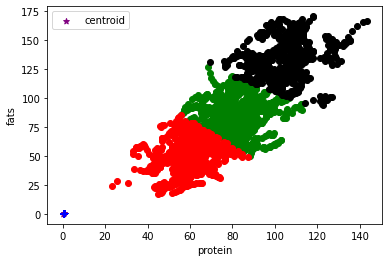

In [11]:
#%% Build classifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# =============================================================================
# plt.xlabel('protein')
# plt.ylabel('fat')
# plt.plot(df_predictors.proteins,df_predictors.fats,color='blue',marker='+',linestyle='')
# =============================================================================
df_cluster = df_predictors
scaler = MinMaxScaler().fit(df_predictors)

X_means = scaler.transform(df_predictors)
x_df = pd.DataFrame(X_means)

plt.xlabel('protein')
plt.ylabel('fat')
plt.plot([item[0] for item in X_means],[item[1] for item in X_means],color='blue',marker='+',linestyle='')

km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(x_df[[0,1]])
df_cluster['cluster'] = y_predicted
df_cluster["under"] = df_groups["undernourishment"]


df1 = df_cluster[df_cluster.cluster==0]
df2 = df_cluster[df_cluster.cluster==1]
df3 = df_cluster[df_cluster.cluster==2]

plt.scatter(df1["proteins"],df1["fats"],color='green')
plt.scatter(df2["proteins"],df2["fats"],color='red')
plt.scatter(df3["proteins"],df3["fats"],color='black')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.xlabel('protein')
plt.ylabel('fats')
plt.legend()

df1.name, df2.name, df3.name = "Cluster 1", "Cluster 2", "Cluster 3"

df_list = [df1, df2, df3]
list_method = {"Method" : ["SVR (rbf)", "Kernel Ridge", "SVR (linear)", "SVR (poly)"]}

new_df_c = pd.DataFrame(data = list_method)

for array in df_list:
    name = array.name
    y = array["under"].to_numpy()
    array = array[['carbs','proteins','fats']]
    list_scores = []
    X = array.to_numpy()
    scaler = StandardScaler().fit(X) # scaler conserva los datos (media y sd) de X, para escalar futuros inputs
    X = scaler.fit_transform(X)
    svr.fit(X,y)
    kr.fit(X, y)
    svr_lin.fit(X,y)
    svr_poly.fit(X, y)
    
    print(
        "The best parameters for SVR (rbf) on", name,"are %s with a score of %0.2f"
        % (svr.best_params_, svr.best_score_)
    )
    
    print(
        "The best parameters for Kernel Ridge on", name,"are %s with a score of %0.2f"
        % (kr.best_params_, kr.best_score_)
    )
    
    print(
        "The best parameters for SVR (linear)", name,"are %s with a score of %0.2f"
        % (svr_lin.best_params_, svr_lin.best_score_)
    )
    
    print(
        "The best parameters for SVR (poly)", name,"are %s with a score of %0.2f"
        % (svr_poly.best_params_, svr_poly.best_score_)
    )
    list_scores = [svr.best_score_, kr.best_score_, svr_lin.best_score_, svr_poly.best_score_]
    new_df_c[name] = list_scores
print(new_df_c)

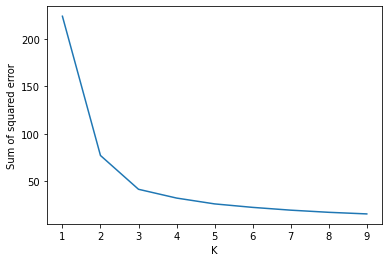

In [ ]:
#%% Scree plot

sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(x_df[[0,1]])
    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [ ]:
# Neural Network

from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

regr.predict(X_test[:2])
regr.score(X_test, y_test)

0.7568769268829592

In [ ]:
#%% Neural network
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X = df_predictors.to_numpy()
y = df_target['undernourishment'].to_numpy()
# escalar las columnas:
scaler = StandardScaler().fit(X) # scaler conserva los datos (media y sd) de X, para escalar futuros inputs
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
regr = MLPRegressor(random_state=1, max_iter=500, solver="lbfgs").fit(X_train, y_train)

regr.predict(X_test[:2])

print(regr.score(X_test, y_test))